<a href="https://colab.research.google.com/github/tirals88/Deep-Learning-from-Scratch/blob/main/1%EA%B6%8C_6%EC%9E%A5_(1)_%ED%95%99%EC%8A%B5_%EA%B4%80%EB%A0%A8_%EA%B8%B0%EC%88%A0%EB%93%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#드라이브연동
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd '/content/drive/My Drive/DLscratch/deep-learning-from-scratch/ch06'

/content/drive/My Drive/DLscratch/deep-learning-from-scratch/ch06


# 학습 관련 기술들

이번 장에서는 가중치 매개변수의 최적값을 탐색하는 최적화 방법, 가중치 매개변수 초깃값, 하이퍼파라미터 설정 방법 등 신경망 학습에서 중요한 부분들을 다루게 된다.

---

## 1. 매개변수 갱신

신경망 학습의 목적은 손실 함수의 값을 가능한 한 낮추는 매개변수를 찾는 것이다. 
결국 매개변수의 최적값을 찾게 된다. 

이전까지는 매개변수의 기울기를 이용하여 갱신의 반복을 통해 최적화를 해왔다.

이것이 '**확률적 경사 하강법(Stochastic Gradient Descent)**이라는 단순한 방법이고 나름 똑똑한 방법이었다.

### SGD 확률적 경사 하강법

수식으로 표현하면 아래와 같다.
$$𝐖 ← 𝐖 - 𝜼\frac{\partial L}{\partial 𝐖}$$
$𝐖$는 가중치 매개변수이고 $\frac{∂ L}{\partial 𝐖}$은 $𝐖$에 대한 손실 함수의 기울기 이다. 그리고 $𝜼$는 학습률을 의미하는데 실제로는 0.01이나 0.001과 같은 값을 미리 정하여 사용한다.

In [7]:
# SGD 구현

class SGD:
  def __init__(self, lr = 0.01):
    self.lr = lr

  def update(self, params, grads):
    for key in params.keys():
      params[key] -= self.lr * grads[key]

SGD 클래스를 사용하면 신경망 매개변수의 진행을 다음과 같이 수행할 수 있다.

```
network = TwoLayerNet(...)
optimizer = SGD()

for i in range(10000):
  ...
  x_batch, t_batch = get_mini_batch(...) # 미니배치
  grads = network.gradient(x_batch, t_batch)
  parmas = network.params
  optimizer.update(params, grads)
```
**optimizer**는 최적화를 행하는 자를 뜻하며 이 코드에서는 SGD가 그 역할을 한다.
다른 optimizer를 사용할 때는 optimizer = Momentum()과 같이 바꾸면 SGD가 Momentum으로 바뀌게 된다.

##2. SGD 단점

SGD 는 단순하고 구현이 쉽다 하지만, 문제에 따라 비효율적일 수 있다.

예를 들어 함수 $f(x,y) = \frac{1}{20}x^2 + y^2$ 의 최솟값을 구하는 문제를 생각해볼 수 있다.

함수의 기울기를 그려보면 다음 그림과 같이 나오게 된다.

<img src = "https://github.com/tirals88/Deep-Learning-from-Scratch/blob/main/deep_learning_images/fig%206-2.png?raw=true" width = 500 >

그림을 보면 대부분의 점에서 y축 방향은 가파른데 x축 방향으로는 완만한 것을 볼 수 있다. 또한 최솟값이 되는장소인 $(x,y) = (0, 0)$이지만 기울기 대부분이 이 방향을 가리키지 않는다는 것이다.

이제 이 함수에 SGD 를 적용 시켜볼 것이다. 초기값을 $(x, y) = (-7.0, 2.0)$으로 설정하면 아래와 같은 그림이 나온다.

<img src = "https://github.com/tirals88/Deep-Learning-from-Scratch/blob/main/deep_learning_images/fig%206-3.png?raw=true" width = 500 >

최솟값을 향해 학습이 진행이 되고있는 모습을 볼 수 있다. 하지만 매우 크게 지그재그로 움직이는 것을 볼 수 있어 이는 비효율적인 것을 알 수 있다.

다시 말해서 SGD 의 단점은 이러한 **비등방성 anisotropy 함수**에서는 탐색경로가 비효율적이라는 것이다.

- 비등방성 함수 anisotropy function : 방향에 따라 성질, 즉 여기에서는 기울기가 달라지는 함수

이러한 상황에서  SGD 같이 무작정 기울어진 방향으로 진행하는 단순한 방식보다 더 영리한 묘안이 간절해지게 된다.

따라서 단점을 개선해주는 모멘텀Momentum, AdaGrad, Adam 이라는 방법들을 베울 것이다.

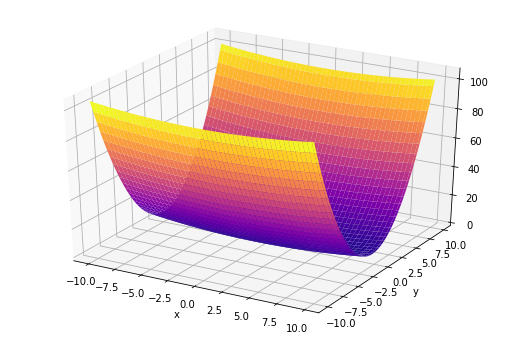

In [19]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

x = np.arange(-10, 10, 0.2)
y = x
x_m, y_m = np.meshgrid(x,y)

z = (1/20)*x_m**2 + y_m**2

ax.plot_surface(x_m, y_m ,z, cmap = 'plasma')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

##3. 모멘텀

모멘텀은 '운동량'을 뜻하는 단어로 수식으로 쓰면 다음과 같다.

$$𝐯 \leftarrow 𝛂 𝐯 -𝜂\frac{\partial L}{\partial 𝐖}$$
$$𝐖 ← 𝐖 + 𝐯$$

새로운 변수인 𝐯는 물리에서의 속도에 해당하며 기울기 방향으로 힘을 받아 물체가 가속된다는 물리법칙과 유사하게 만든 것이다.


In [21]:
#모멘텀 구현

class Momentum():
  def __init__(self, lr = 0.01, momentum = 0.9):
    self.lr = lr
    self.momentum = momentum
    self.v = None

  def update(self, params, grads):
    if self.v is None:
      self.v = {}
      for key, val in params.items():
        self.v[key] = np.zeros_like(val)

    for key in params.keys():
      self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
      params[key] += self.v[key]

위 코드에서 인스턴스 변수 v 가 속도이다 초기화 때는 아무 값도 담지 않고 있다가 update()를 통해 매개변수와 같은 구조의 데이터를 딕셔너리 변수로 저장한다.

모멘텀을 사용하여 최적화 문제를 풀게 되면 다음과 같은 그래프가 나오게 된다.

<img src = "https://github.com/tirals88/Deep-Learning-from-Scratch/blob/main/deep_learning_images/fig%206-5.png?raw=true" width = 500 >

이를 보년 SGD 에 비해서 지그재그의 정도가 덜한 것을 알 수 있다.

이는 x축의 힘은 아주 작지만 방향은 변하지 않아서 한 방향으로 일정하게 가속하기 때문이다.

반대로 y축의 힘은 크지만 위아래로 번갈아받아서 상충하여 y축 방향의 속도는 안정적이지 않다.

전체적으로 SGD보다 x축 방향으로 빠르게 다가가 지그재그 움직임이 줄어든다.